<a href="https://colab.research.google.com/github/educardenas97/Vacunados/blob/master/Model_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.mspbs.gov.py/xweb/vacunados.csv  -P /tmp/ -o vacunados.csv --no-check-certificate

In [ ]:
!pip install category_encoders

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
import category_encoders as ce
import tensorflow as tf

csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vacunados/dataset/vacunados.csv', sep=';')
csv_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/vacunados/dataset/padron.csv', sep=',')

In [ ]:
#Filter data
data = csv.copy()
data = data.drop_duplicates()
data = data[data['cedula'].astype(str).str.isdigit()]
data['cedula'] = pd.to_numeric(data['cedula'])
data['dosis'] = data['dosis'].astype(int)
data['fecha_aplicacion'] = pd.to_datetime(data['fecha_aplicacion']).dt.date
data['semana'] = data['fecha_aplicacion'] -  data['fecha_aplicacion'].min()
data['semana'] = (data['semana']).dt.days
data = data[data['cedula']<90000000]
data = data[data['dosis'] == 1]
#Inner join
padron = csv_2.copy().drop(columns='date')
join_dataframe = data.join(padron.set_index('id'), on='cedula', how='inner')
join_dataframe.drop(inplace=True, columns=['actualizado_al','fecha_aplicacion','nombre','apellido','establecimiento','dosis'])

print(join_dataframe.columns)

Index(['cedula', 'descripcion_vacuna', 'semana', 'year'], dtype='object')


                                     cedula  semana  year
descripcion_vacuna                                       
COVAXIN COVID-19                   970627.0      66  1952
HAYAT VAX COVID-19                 741629.5     100  1958
ASTRAZENECA-CHADOX1-S - COVID-19  1201764.5     114  1964
SPUTNIK V COVID-19                3198196.5     133  1981
MODERNA - COVID -19               3510755.0     134  1984
CORONAVAC COVID-19                3784224.0      20  1986
PFIZER - COVID -19                4499542.5     150  1991
SINOPHARM COVID-19                5283778.5     241  1996


Text(0.5, 0, 'semana')

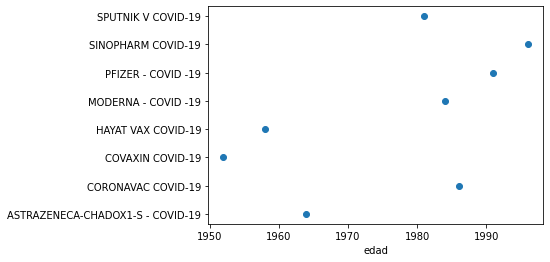

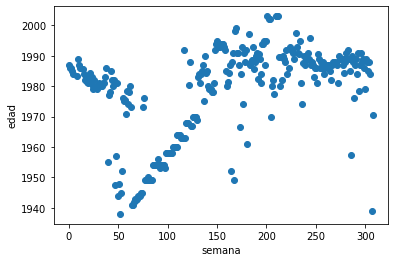

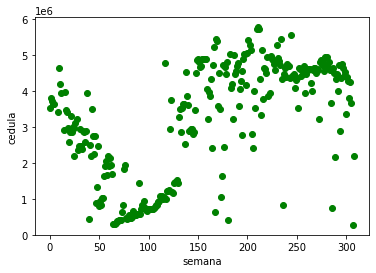

In [ ]:
#Distribución
#join_dataframe['year'].plot.kde()
#Primera parte
mean = join_dataframe
view = mean.groupby('descripcion_vacuna').median()
print(view.sort_values(by='year'))
#Edad vs vacunas
fig, ax = plt.subplots()
ax.scatter(view['year'], view.index)
ax.set_xlabel('edad')
#Semanas vs edad
fig, ax = plt.subplots()
view = mean.groupby('semana').median()
ax.scatter(view.index, view['year'])
ax.set_ylabel('edad')
ax.set_xlabel('semana')
#Semanas vs cedula
fig, ax = plt.subplots()
view = mean.groupby('semana').median()
ax.scatter(view.index, view['cedula'], c='green')
ax.set_ylabel('cedula')
ax.set_xlabel('semana')


In [ ]:
import plotly.express as px
fig = px.scatter_3d(join_dataframe.sample(n=199), x='cedula', y='semana', z='year', color='descripcion_vacuna')
fig.show()

In [ ]:
encoder = ce.OneHotEncoder(cols='descripcion_vacuna',handle_unknown='return_nan',return_df=True,use_cat_names=True)

#encoder=ce.sum_coding.SumEncoder(cols='City',verbose=False,)
dataframe_encoding = encoder.fit_transform(join_dataframe)
print(dataframe_encoding.columns)

#normalize
dataframe_encoding['cedula'] = dataframe_encoding['cedula'] / dataframe_encoding['cedula'].abs().max()
#dataframe_encoding['year'] = dataframe_encoding['year'] / dataframe_encoding['year'].abs().max()
dataframe_encoding['semana'] = dataframe_encoding['semana'] / dataframe_encoding['semana'].abs().max()
#test data
test_data = dataframe_encoding.sample(frac=0.3, random_state=1, weights='cedula')
test_data = test_data.set_index('cedula')
dataframe_encoding = dataframe_encoding.set_index('cedula')
dataframe_encoding = dataframe_encoding.drop(index=test_data.index)
dataframe_encoding = dataframe_encoding.reset_index()
test_data = test_data.reset_index()
#train data
output_data = dataframe_encoding['year']
dataframe_encoding = dataframe_encoding.drop(columns='year')
input_data = dataframe_encoding
#print(output_data.to_numpy())
print(output_data.to_numpy())

Index(['cedula', 'descripcion_vacuna_SPUTNIK V COVID-19',
       'descripcion_vacuna_ASTRAZENECA-CHADOX1-S - COVID-19',
       'descripcion_vacuna_PFIZER - COVID -19',
       'descripcion_vacuna_MODERNA - COVID -19',
       'descripcion_vacuna_HAYAT VAX COVID-19',
       'descripcion_vacuna_COVAXIN COVID-19',
       'descripcion_vacuna_CORONAVAC COVID-19',
       'descripcion_vacuna_SINOPHARM COVID-19', 'semana', 'year'],
      dtype='object')
[1976 1985 1973 ... 1979 1986 1971]


In [ ]:
#print(output_data)
#print(input_data.keys())
#arquitectura de la red
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=[len(input_data.keys())]))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(49, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(49, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='Adam', loss='MeanAbsoluteError', metrics=['mae', 'mse'])
model.summary()
model.fit(x=input_data, y=output_data, validation_split=0.1, epochs=3)

output_test = test_data['cedula']
input_test = test_data.drop(columns='cedula')

print("Evaluate on test data")
results = model.evaluate(input_test.to_numpy(), output_test.to_numpy())
print("test loss, test acc:", results)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_363 (Dense)           (None, 24)                264       
                                                                 
 dense_364 (Dense)           (None, 49)                1225      
                                                                 
 dense_365 (Dense)           (None, 24)                1200      
                                                                 
 dense_366 (Dense)           (None, 24)                600       
                                                                 
 dense_367 (Dense)           (None, 49)                1225      
                                                                 
 dense_368 (Dense)           (None, 24)                1200      
                                                                 
 dense_369 (Dense)           (None, 1)               

In [ ]:
evaluate = []
evaluate.append(659580/join_dataframe['cedula'].abs().max())
evaluate.append(1)
evaluate.append(0)
evaluate.append(0)
evaluate.append(0)
evaluate.append(0)
evaluate.append(0)
evaluate.append(0)
evaluate.append(0)

date = datetime.strptime('01/04/2021', '%d/%m/%Y').now().date() -  data['fecha_aplicacion'].min()
date = date.days/join_dataframe['semana'].abs().max()
evaluate.append(date)
#*join_dataframe['year'].abs().max()
print(model.predict([evaluate]))

[[1968.0468]]
